In [42]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE

import pickle

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.models import load_model

import copy
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('../bhaven/Tuned_logReg_all_training_data.pkl', 'rb') as file:  
    Logreg = pickle.load(file)

In [3]:
data_train = pd.read_csv("../lipika/cleaned_2013_14", low_memory = False);
data_test = pd.read_csv("../lipika/cleaned_2015", low_memory = False);
data_test = data_test.dropna()
data_train = data_train.dropna()
data_test = data_test[data_test.int_rate < 0.5]
data_train = data_train[data_train.int_rate < 0.5]

In [4]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

cols_to_drop_training = ['loan_status', 'paid', 'amnt', 'total_pymnt', 
                         'term_adj', 'zip_code']
x_train, y_train = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)


def create_df(data_1, data_2, penal):
    df = pd.DataFrame(data_1)
    #df['proba'] = df.proba.map(lambda x: x[0])
    #df['pred'] = df.pred.map(lambda x:x[0])
    
    df['int_rate'] = data_2['int_rate']
    df['amnt'] = data_2['amnt']
    df['total_pymnt'] = data_2['total_pymnt']
    df['term_adj'] = data_2['term_adj']
    df['ROI'] = (((1 + df['int_rate'])*(1-df['proba']))+(df['proba']*drr*penal))-1

    df['Real_ROI'] = df['amnt']*(((df['total_pymnt']/df['amnt'])**(1/df['term_adj']))-1)
    df['annualized_amnt'] = df['amnt'] #*(1/df['term_adj'])
    
    df['zip_code'] = data_2['zip_code']
    
    return df

distress = data_train[data_train.paid == 1]
drr = (np.sum(distress.total_pymnt)/np.sum(distress.amnt))**(1/np.mean(distress.term))
#print('Distressed Return Rate: ', drr)

In [5]:
train_data = {'proba' : Logreg.predict_proba(x_train)[:, 1], 'pred' : Logreg.predict(x_train), 'true_val' : y_train}
test_data = {'proba' : Logreg.predict_proba(x_test)[:, 1], 'pred' : Logreg.predict(x_test), 'true_val' : y_test}
Logreg_train = create_df(train_data, data_train, 0.5)
Logreg_test =  create_df(test_data, data_test, 0.5)
#print('Training Accuracy: ', accuracy_score(Logreg_train.pred, Logreg_train.true_val))
#print('Test Accuracy: ', accuracy_score(Logreg_test.pred, Logreg_test.true_val))

In [6]:
NN_train = pd.read_csv("NN_train.csv", low_memory=False, delimiter = '\t')
NN_test = pd.read_csv("NN_test.csv", low_memory=False, delimiter = '\t')
#print('Training Accuracy: ', accuracy_score(NN_train.pred, NN_train.true_val))
#print('Test Accuracy: ', accuracy_score(NN_test.pred, NN_test.true_val))

**Formulating ROI**

Having used several different models to assign probabilities of default to the loans in our training and test sets, we needed to incorporate these probabilities into our investment strategy. We decided to use these probabilities of default to calculate a Return on Investment (ROI) for every loan in the dataset. By only investing in the loans with the best predicted ROI, we would hope to achieve stronger returns than the broader market. 

Our formula for expected ROI was:

$$ ROI_{P}=\frac{(1+I)A(1-P_d) + \alpha P_d R - A}{A} $$

Where $A$ refers to the Loan amount, $P(d)$ to the probability of default assessed by our classification models, $I$ to the interest rate charged on the loan being considered and $R$ the expected amount to be returned should a loan default. The predicted ROI is the expected return from all of our loans, so in the case when we don't expect loans to default ($1-P(d)$ of the time) we would receive $(1+I)A$ from the borrower. Should the borrower default we would expect to still receive some money from them: defaults rarely happen before any payments have been made, and because of charge-offs and other measures, on average, investors get back 89 cents on the dollar from their distressed loans. Since we want to bias our model away from investing in loans that might default (due to the large variance in recovery outcomes) we apply a penalty term, $\alpha$ = 0.5, so that the ROI's returned by our model are biased towards a subset of loans less likely to default than their peers. 

Using this formula we are able to predict ROI for every loan in our training and test sets. We then rank the loans according to predicted ROI, and invest only in the top tranche. Plots of initially predicted ROI across loans that eventually paid off or defaulted are shown above for both the Logistic Regression model and our Neural Net. 

**Market Efficiency**

We would expect the loan market to be very efficient, and to price a borrower's risk into their loan. We know this is the case, since riskier borrowers (by loan grade) need to pay higher interest rates to qualify for credit. Because our ROI formulation represents a balance between a borrowers risk of default, and the interest rate we are charging them, a fully efficient market wouldn't present us with opportunities to 'over-perform' since these two competing attributes would be expected to work against each other such that every loan had a similar predicted ROI. [Lending Club](https://blog.lendingclub.com/next-wave-innovation-marketplace-lending/) claims to have been founded on the premise that a peer-to-peer lending model would work to make small loans more efficient by making them accessible to large investors. Large institutional investors increasingly use the Lending Club platform as a way to diversify their investments, making this a tough market place to compete in as an individual.

**Comparison of Models**

Our investment strategy relied on being able to predict ROI for loans, and for those loans to then perform as expected. From the plot above, showing ROI distributions for the Logistic Regression model and the Neural Net model, we can see that the best split in the proposed distributions was for the Logistic Regression model. We decided to use this model as the base for our final investment simulation, where we would predict a subset of loans we ought to invest in going forwards in 2015, and then we would compare the performance of this subset with the performance of the general market come the end of the loan life. 

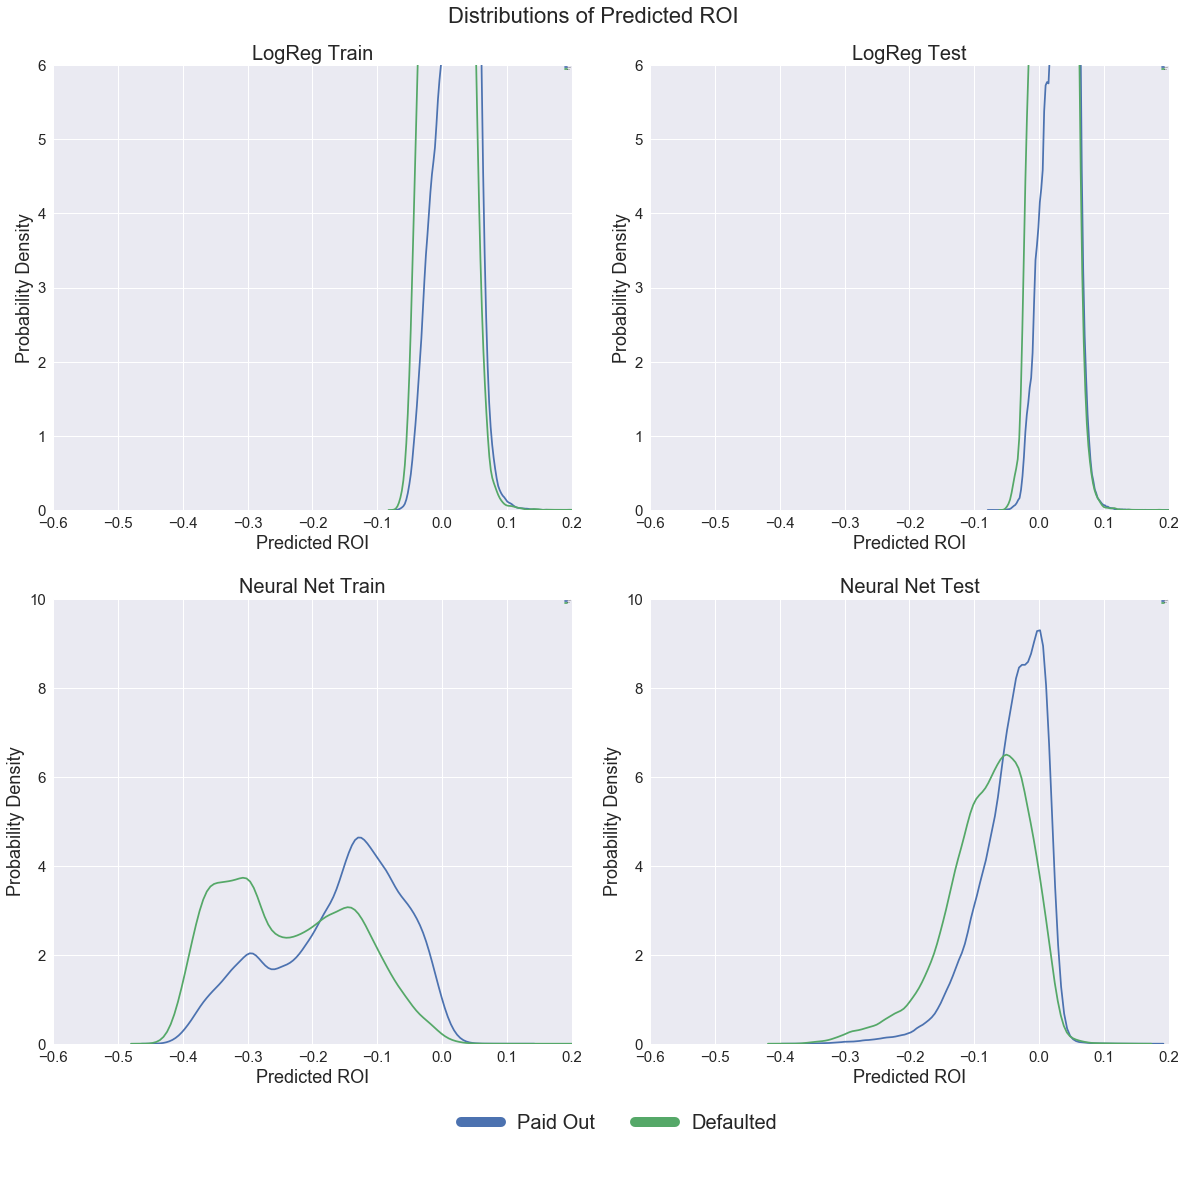

In [28]:
warnings.filterwarnings("ignore")

models = [Logreg_train, Logreg_test, NN_train, NN_test]
titles = ['LogReg Train', 'LogReg Test', 'Neural Net Train', 'Neural Net Test']
fig = plt.figure(figsize=(20, 18)) 
fig.subplots_adjust(hspace=0.2, wspace=0.15)
plt.suptitle('Distributions of Predicted ROI', size = 22,  y=0.925)

for n, model in enumerate(models):
    ax = plt.subplot(2,2, n+1)
    sns.kdeplot(model.loc[model.true_val == 0,'ROI'], label = 'Paid Out', ax=ax);
    sns.kdeplot(model.loc[model.true_val == 1,'ROI'], label = 'Defaulted', ax=ax);
    ax.set_xlim(-0.6, 0.2)
    if n <= 1:
        ax.set_ylim(0, 6)
    else:
        ax.set_ylim(0, 10)
        
    ax.tick_params(labelsize = 15)
    ax.set_xlabel('Predicted ROI', fontsize = 18)
    ax.set_ylabel('Probability Density', fontsize = 18)
    ax.set_title('{0}'.format(titles[n]), fontsize = 20)
    ax.legend(loc = 'best', fontsize = -1)
    
handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(10) for ha in handles ]
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 20, bbox_to_anchor = (0.43, 0.02))
plt.show()

**Tuning ROI Predictions**

The penalty parameter in our ROI prediction model was an important parameter to tune, since it determined the extent to which our model was biased against loans that were assessed to have a higher probability of default, but also offered significant potential pay-off. We decided to rank our loans based on this predicted ROI. Our data included information on all the payments made by borrowers having received a loan, so we used this information to calculate the real ROI for all our loans, so as to determine the relative performance of the subset we would select based on our predictions.

We used information on payments made by the borrowers to formulate a loan's real ROI:

$$ROI_R = A\left[\left(\dfrac{P}{A}\right)^{\dfrac{1}{term}} - 1\right]$$

To normalise this for the size of the loan, across a subset of selected loans, we suggested that:

$$ROI_{R} = \dfrac{\sum A\left(\left(\dfrac{P}{A}\right)^{\dfrac{1}{term}} - 1\right)}{\sum A}$$

This allows us to evaluate the performance of the entire portfolio as well as a subset of it. We decided to create strategy curves for our ranked dataframe. A strategy curve plots the real ROI of all the loans being considered in a certain proportion of the ranked loan-set as we work from the top. In an ideal curve, we would expect the real ROI to be relatively high for the upper tranche of loans and then for it to decrease to the portfolio baseline value as the proportion of loans increases from just the best predicted ones until the full loan-set is included. 

We decided to tune the penalty term ($\alpha$) in our ROI prediction model, controlling the amount of money we would expect a defaulted loan to return. By tuning this parameter (between 0 - assume all defaults return no money, and 1 - assume defaulted loans return 89 cents on the dollar) on the training set, and considering which strategy curve would best represent an optimal ranking of the loans, we were able to make ROI predictions on our test set, to rank the test loans, and to create a strategy curve for this set, representative of our ability to succesfully rank loans according to their investment value.

The plot below shows our strategy curves for the training set as the parameter $\alpha$ in our predicted ROI formulation was varied. It is clear that as $\alpha$ increases towards 1, the value at which we would expect our model to be most accurate, since at this rate we fully account for the difference in repayment rates between defaulted and non-defaulted loans, our loan ranking improves. We see this from the fact that the strategy curves tend towards being monotonically decreasing.

Since using a value of $\alpha$ larger than 1 makes no sense, even though it gives us a better strategy curve than with $\alpha$ equal to 1 on our training set, so we decided to use $\alpha$ of one going forwards to simulate our test data. 

In [8]:
def create_strategy_curve(df):
    df['cumsum_prop_loans'] = df.amnt.cumsum()/np.sum(df.amnt)
    df['cumsum_ROI'] = df.Real_ROI.cumsum()/df.annualized_amnt.cumsum()
    return df

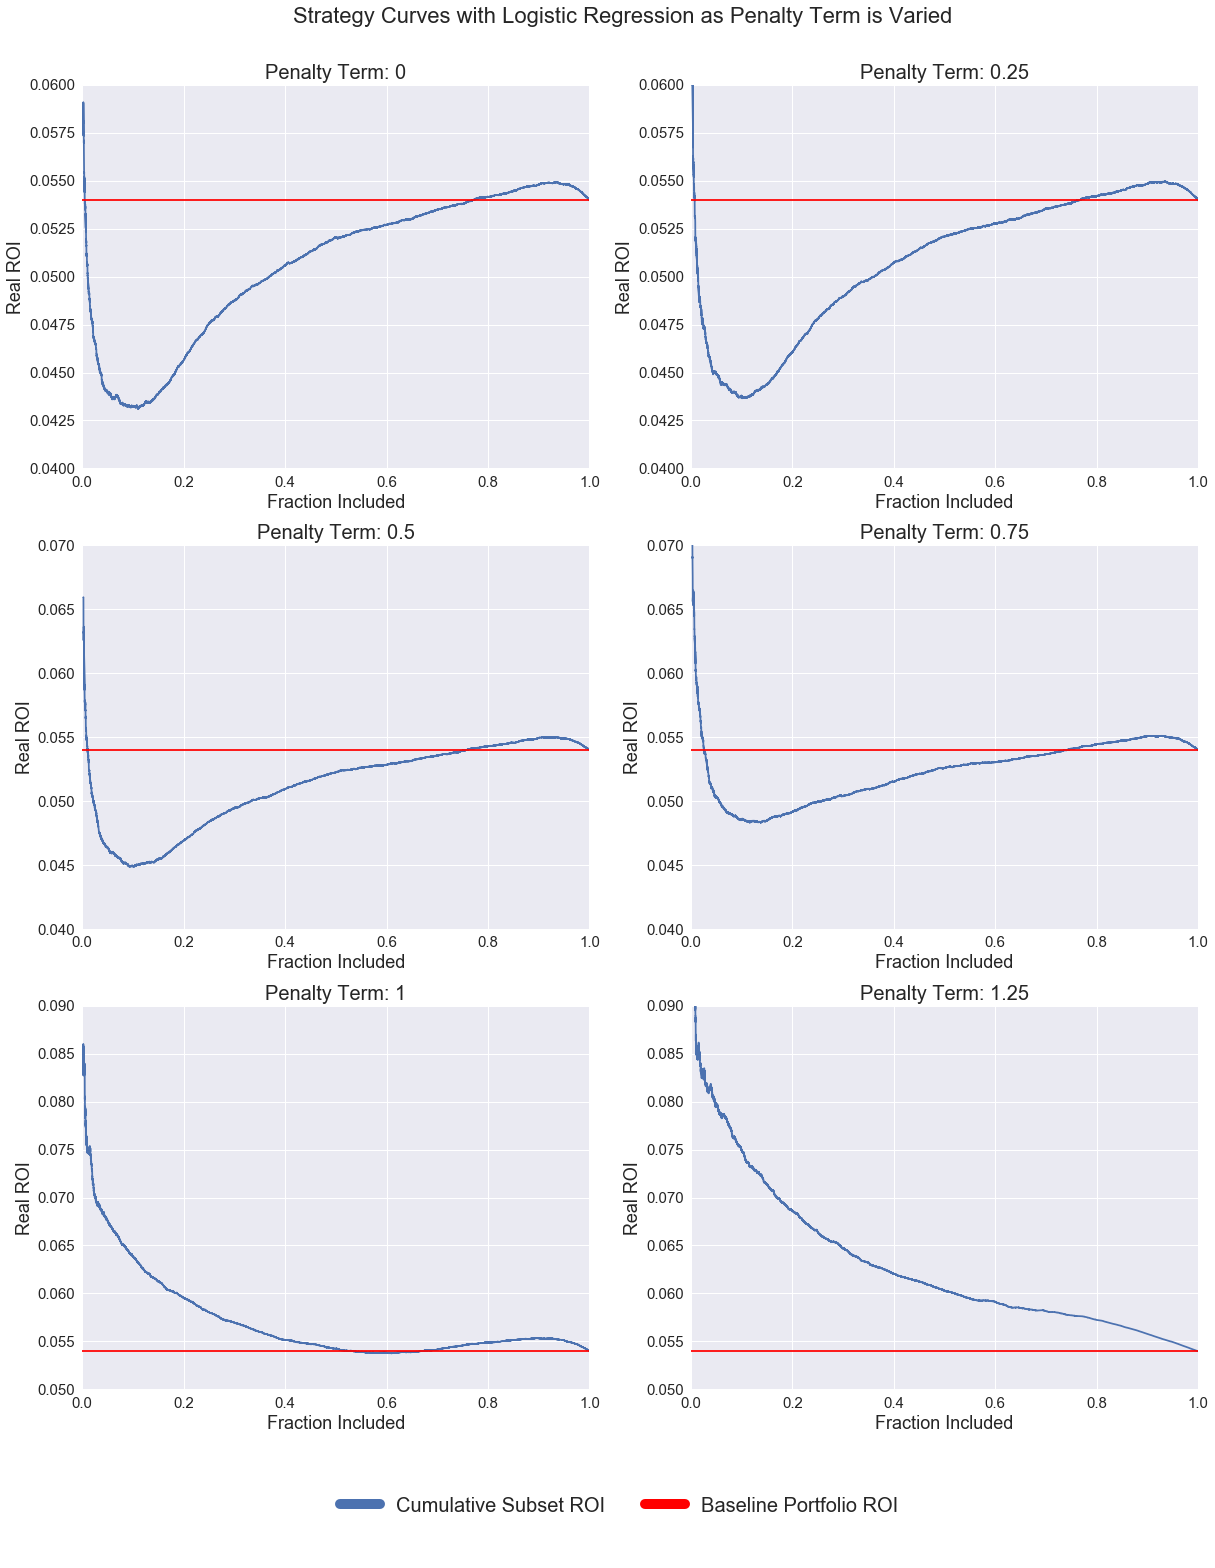

In [9]:
fig = plt.figure(figsize=(20, 24)) 
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.suptitle('Strategy Curves with Logistic Regression as Penalty Term is Varied', size = 22,  y=0.925)


penals = [0, 0.25, 0.5, 0.75, 1, 1.25]
i = 500

for n, penal in enumerate(penals):
    Logreg_train_penal = create_df(train_data, data_train, penal)
    Logreg_train_penal = Logreg_train_penal.sort_values(by=['ROI'], ascending=False)
    Logreg_train_penal = create_strategy_curve(Logreg_train_penal)
    
    ax = plt.subplot(3,2, n+1)
    plt.plot(Logreg_train_penal.cumsum_prop_loans[i:], Logreg_train_penal.cumsum_ROI[i:], label = 'Cumulative Subset ROI')
    plt.axhline(np.sum(Logreg_train_penal.Real_ROI)/np.sum(Logreg_train_penal.annualized_amnt), color = 'r', label = 'Baseline Portfolio ROI')
    ax.set_xlim(0,1)
    if n <= 1:
        ax.set_ylim(0.04, 0.06)
    elif n <= 3 and n > 1:
        ax.set_ylim(0.04, 0.07)
    else:
        ax.set_ylim(0.05, 0.09)
    ax.tick_params(labelsize = 15)
    ax.set_xlabel('Fraction Included', fontsize = 18)
    ax.set_ylabel('Real ROI', fontsize = 18)
    ax.set_title('Penalty Term: {0}'.format(penal), fontsize = 20)
    #ax.legend(loc = 'best', fontsize = -1)
    
handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(10) for ha in handles ]
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 20, bbox_to_anchor = (0.43, 0.02))
plt.show()

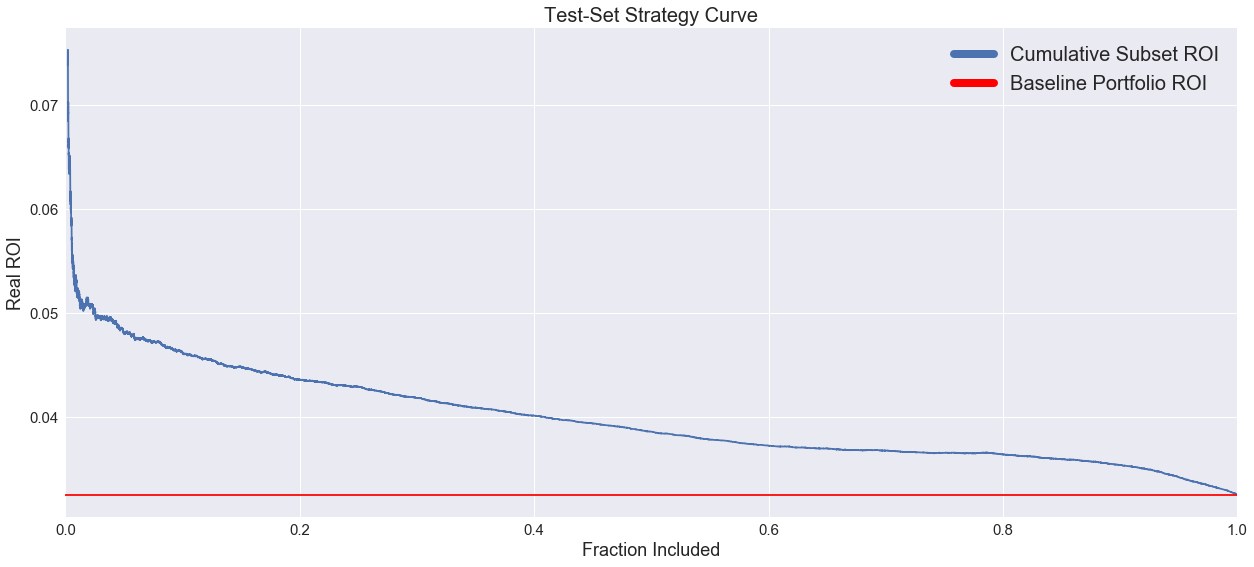

In [10]:
Logreg_train = create_df(train_data, data_train, 1)
Logreg_test =  create_df(test_data, data_test, 1)
Logreg_train = Logreg_train.sort_values(by=['ROI'], ascending=False)
Logreg_test = Logreg_test.sort_values(by=['ROI'], ascending=False)
Logreg_train = create_strategy_curve(Logreg_train)
Logreg_test = create_strategy_curve(Logreg_test)

fig = plt.figure(figsize=(21, 9)) 

i = 500
plt.plot(Logreg_test.cumsum_prop_loans[i:], Logreg_test.cumsum_ROI[i:], label = 'Cumulative Subset ROI')
plt.axhline(np.sum(Logreg_test.Real_ROI)/np.sum(Logreg_test.annualized_amnt), color = 'r', 
            label = 'Baseline Portfolio ROI')

plt.xlim(0,1)
plt.tick_params(labelsize = 15)
plt.xlabel('Fraction Included', fontsize = 18)
plt.ylabel('Real ROI', fontsize = 18)
plt.title('Test-Set Strategy Curve', fontsize = 20)
plt.legend(loc = 'best', fontsize = -1)
    
handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(8) for ha in handles ]
plt.legend(handles, labels, loc='upper right', ncol = 1, fontsize = 20)
plt.show()

With this value of $\alpha$, our curve for the test data is decreasingly monotonic, indicative of the fact that our predictions for loan performance match up really nicely with the actual performance of those loans. This curve forms the basis of our investment strategy, with a certain amount of money available to an investor, if they were to buy all the loans in order of $ROI_P$ rank predicted by our Logistic Regression model, they would almost certainly outperform the market since we have shown our ranking system to be succesful. 

In [11]:
Logreg_train['cumsum_amnt'] = Logreg_train.amnt.cumsum()
Logreg_test['cumsum_amnt'] = Logreg_test.amnt.cumsum()

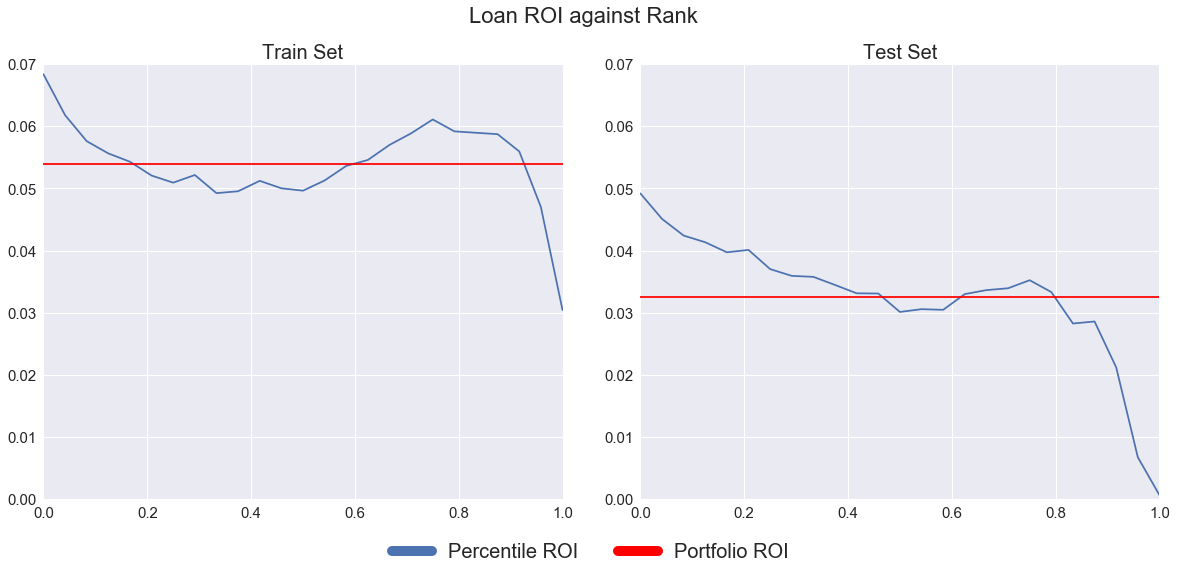

In [12]:
training_band_ROI = []
test_band_ROI = []
k = 25

train_buckets = np.sum(Logreg_train.amnt)/k
for i in range(1, k+1):
    upper = train_buckets*i 
    lower = train_buckets*(i-1)
    temp = Logreg_train[Logreg_train.cumsum_amnt > lower]
    temp = temp[temp.cumsum_amnt < upper]
    band_ROI = np.sum(temp.Real_ROI)/np.sum(temp.amnt)
    training_band_ROI.append(band_ROI)

test_buckets = np.sum(Logreg_test.amnt)/k
for i in range(1, k+1):
    upper = test_buckets*i 
    lower = test_buckets*(i-1)
    temp = Logreg_test[Logreg_test.cumsum_amnt > lower]
    temp = temp[temp.cumsum_amnt < upper]
    band_ROI = np.sum(temp.Real_ROI)/np.sum(temp.amnt)
    test_band_ROI.append(band_ROI)
    
fig = plt.figure(figsize=(20, 8)) 
fig.subplots_adjust(hspace=0.2, wspace=0.15)
plt.suptitle('Loan ROI against Rank', size = 22,  y=0.98)


curves = [training_band_ROI, test_band_ROI]
titles = ['Train Set', 'Test Set']
xs = np.linspace(0, 1, k, endpoint = True)

for n, curve in enumerate(curves):
    ax = plt.subplot(1,2, n+1)
    plt.plot(xs, curve, label = 'Percentile ROI')
    plt.axhline(np.mean(curve), color = 'r', label = 'Portfolio ROI')
    ax.set_xlim(0, 1)
    ax.tick_params(labelsize = 15)
    ax.set_title('{0}'.format(titles[n]), fontsize = 20)
    ax.set_ylim(0,0.07)
    #ax.legend(loc = 'best', fontsize = -1)
    
handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(10) for ha in handles ]
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 20, bbox_to_anchor = (0.41, -0.01))
plt.show()
    
plt.show()

In [43]:
P = 200e6

subset_test = Logreg_test[Logreg_test.cumsum_amnt <  P]
subset_train = Logreg_train[Logreg_train.cumsum_amnt <  P]

subset_test_small = Logreg_test[Logreg_test.cumsum_amnt <  5000000]
subset_train_small = Logreg_train[Logreg_train.cumsum_amnt <  5000000]

subset_test_super_small = Logreg_test[Logreg_test.cumsum_amnt <  500000]
subset_train_super_small = Logreg_train[Logreg_train.cumsum_amnt <  500000]

#print(np.sum(subset_test.Real_ROI)/np.sum(subset_test.amnt), 
#      np.sum(Logreg_test.Real_ROI)/np.sum(Logreg_test.amnt)) 

#print(np.sum(subset_train.Real_ROI)/np.sum(subset_train.amnt), 
#      np.sum(Logreg_train.Real_ROI)/np.sum(Logreg_train.amnt)) 

In [14]:
def create_random_subsample(df, x):
    performances = []
    portfolio_sizes = []
    count = 0
    while count < 500:
        df_random_set = pd.DataFrame(columns=df.columns)
        while np.sum(df_random_set.amnt) < x:
            loan = df.sample(n = 500)
            df_random_set = df_random_set.append(loan)
        final_performance = np.sum(df_random_set.Real_ROI)/np.sum(df_random_set.amnt)
        performances.append(final_performance)
        portfolio_sizes.append(np.sum(df_random_set.amnt))
        count += 1   
    return performances, portfolio_sizes

In [16]:
random_perf_test, random_size_test = create_random_subsample(Logreg_test, P)
random_perf_train, random_size_train = create_random_subsample(Logreg_train, P)

random_perf_test_small, random_size_test_small = create_random_subsample(Logreg_test, 5000000)
random_perf_train_small, random_size_train_small = create_random_subsample(Logreg_train, 5000000)

In [31]:
random_perf_test_super_small, random_size_test_super_small = create_random_subsample(Logreg_test, 500000)
random_perf_train_super_small, random_size_train_super_small = create_random_subsample(Logreg_train, 500000)

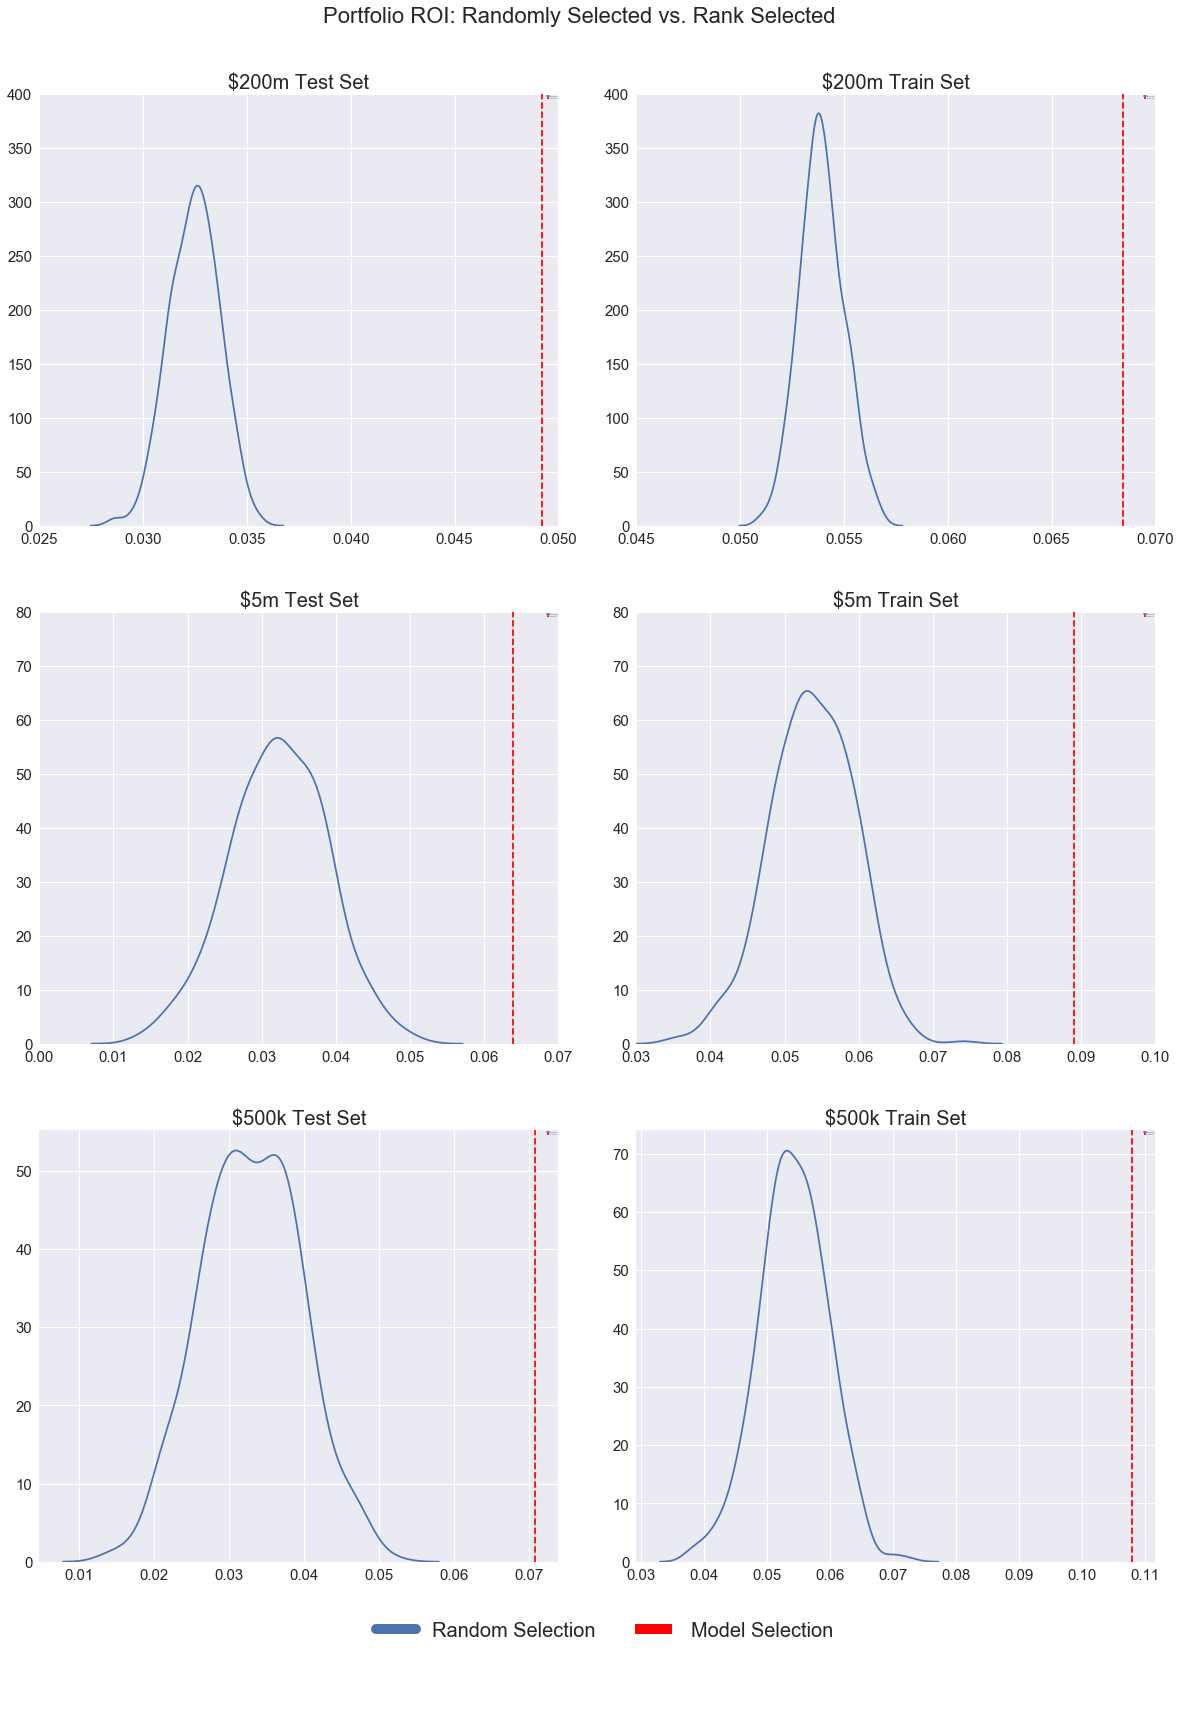

In [41]:
fig = plt.figure(figsize=(20, 27)) 
fig.subplots_adjust(hspace=0.2, wspace=0.15)
plt.suptitle('Portfolio ROI: Randomly Selected vs. Rank Selected', size = 22,  y=0.925)

random_performances = [random_perf_test, random_perf_train, 
                       random_perf_test_small, random_perf_train_small, 
                      random_perf_test_super_small, random_perf_train_super_small]

models = [subset_test, subset_train, 
          subset_test_small, subset_train_small,  
          subset_test_super_small, subset_train_super_small]

titles = ['$200m Test Set', '$200m Train Set', 
          '$5m Test Set', '$5m Train Set', 
          '$500k Test Set', '$500k Train Set']

for n, model in enumerate(models):
    ax = plt.subplot(3,2, n+1)
    sns.kdeplot(random_performances[n], label = 'Random Selection')
    plt.axvline(np.sum(model.Real_ROI)/np.sum(model.amnt), 
                color = 'r', linestyle = '--', label = 'Model Selection')
    ax.tick_params(labelsize = 15)
    ax.set_title('{0}'.format(titles[n]), fontsize = 20)
    if n < 1:
        ax.set_xlim(0.025, 0.05)
        ax.set_ylim(0, 400)
    elif n<2 and n>0:
        ax.set_xlim(0.045, 0.07)
        ax.set_ylim(0, 400)
    if n<3 and n>1:
        ax.set_xlim(0, 0.07)
        ax.set_ylim(0, 80)
    elif n<4 and n>2:
        ax.set_xlim(0.03, 0.1)
        ax.set_ylim(0, 80)
    ax.legend(fontsize = 0)
    
handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(10) for ha in handles ]
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 20, bbox_to_anchor = (0.42, 0.037))
plt.show()

**Analysis**

Having decided to use $\alpha = 1$, we decided to assess our loan ranking system. Above are plots showing how the real ROI of loans varied with percentile rank and how our selected portfolio (best $200 million of loans) performed compared to portfolios of the same size randomly drawn from the dataset by bootstrapping. 

The first plots, showing Real ROI against rank, show that the best ranked loans (zero on our axis) outperformed the whole portfolio while the worst ranked loans (one on our axis) underperformed the portfolio. These results are consistent with the decreasingly monotonic nature of our strategy curves.

We decided to use an investment budget of 200 million dollars, assuming that the strategies we developed would be similar to those developed by institutional investors seeking to invest on the Lending club platform. This figure represented 3.9% of the total loan amount available in both our training and test sets. We bootstrapped from the underlying data 500 times to create randomly selected portfolios of the same size, to compare the performance of the loans selected by the Logistic Regression against a benchmark. The plot of bootstrapped portfolio performance against our model performance clearly shows that our performance was not due to chance: our portfolio consistently outperformed all random sets put together. 